#### 3a. Cara kerja arsitektur generative adversarial network (GAN)

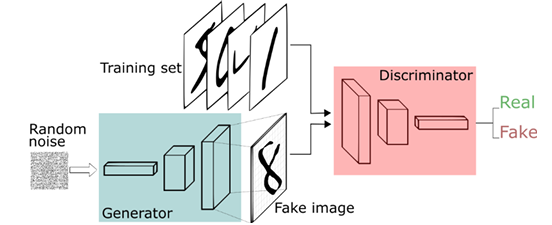

Penjelasan: <br>
GAN merupakan salah satu permasalahan unsupervised learning dengan melatih dua deep neural networks yaitu *Generator* dan *Discriminator*, yang dimana mereka saling bersaing satu sama lain. <br>
Berdasarkan arsitektur GAN yang diberikan, berikut cara kerja GAN:<br>
1. Pada generator, akan diberikan input suatu vector (real image yang diberi noise).
2. Kemudian di dalam model generator, terdapat blok cnn yang bertugas untuk men-generate / membuat fake image yang dibuat semirip mungkin dengan image aslinya.
3. Output dari model generator cnn adalah output fake image.
4. Kemudian fake image hasil generator akan bersama-sama dengan real image dari training set untuk menjadi input pada model discriminator.
5. Model discriminator juga terdiri dari blok cnn classifier yang bertugas untuk mengklasifikasikan / mendeteksi mana image yang asli dan mana image yang palsu. Jika discriminator bisa mengklasifikasikan image generator sebagai fake, maka model discriminator memiliki performa yang baik dan generator perlu meningkatkan performanya dalam men-generate fake image.

Setelah proses GAN diatas dijalankan, dapat dilakukan evaluasi menghitung loss functionnya. Dimana hasil dari loss akan menjadi bahan update weight untuk model generator dan discriminator meningkatkan performa mereka, dimana generator menjadi lebih baik dalam menghasilkan fake images semirip mungkin dengan real images dan discriminator menjadi lebih andal dalam mendeteksi fake image hasil generator.

#### 3b. Arsitektur image generation

#### Library

In [33]:
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Embedding, Flatten, concatenate, Reshape
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image

from numpy.random import randn, randint
from numpy import zeros, ones
from numpy import cov, trace, iscomplexobj
from scipy.linalg import sqrtm

In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#### Load Data

In [ ]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [10]:
path = '/content/drive/MyDrive/Colab Notebooks/Dataset 2'
x_train, y_train = load_mnist(path, kind='train')
x_test, y_test = load_mnist(path, kind='t10k')

In [11]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


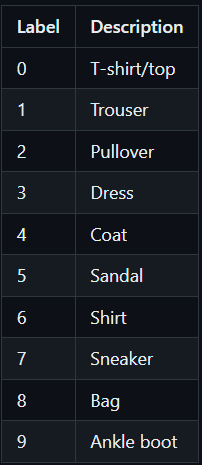

In [12]:
# Filter class Pullover[2] dan Dress[3]
filter_labels = [2, 3]
train_filter = np.isin(y_train, filter_labels)
test_filter = np.isin(y_test, filter_labels)

In [13]:
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

In [14]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(12000, 784)
(12000,)
(2000, 784)
(2000,)


#### Data Normalization

In [15]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28,28, 1)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(12000, 28, 28, 1) (2000, 28, 28, 1) (12000,) (2000,)


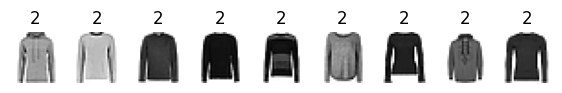

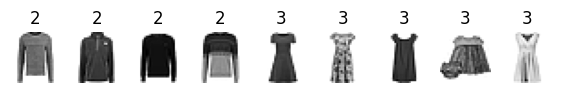

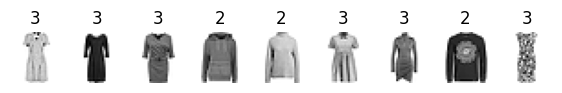

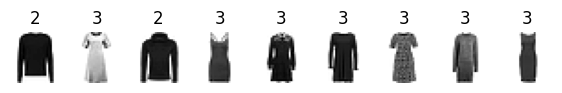

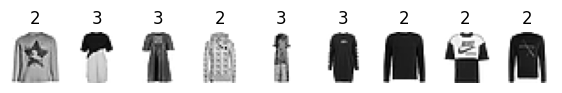

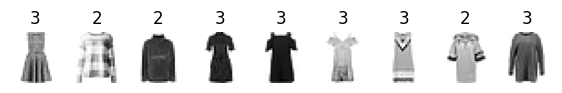

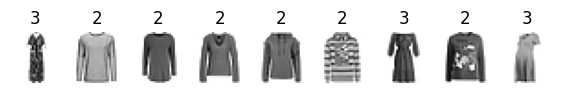

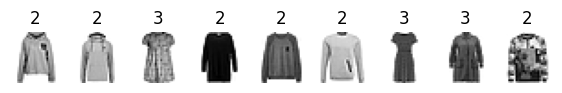

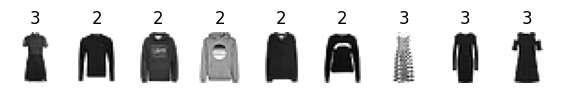

In [16]:
for k in range(9):
    plt.figure(figsize=(7, 7))
    for j in range(9):
        i = np.random.randint(0, 10000)
        plt.subplot(990 + 1 + j)
        plt.imshow(x_train[i], cmap='gray_r')
        plt.axis('off')
        plt.title(y_train[i])
    plt.show()

In [17]:
np.unique(y_train)

array([2, 3], dtype=uint8)

In [18]:
# Mengubah indeks label menjadi [0,1]
y_train = np.where(y_train == 2, 0, y_train)
y_train = np.where(y_train == 3, 1, y_train)
np.unique(y_train)

array([0, 1], dtype=uint8)

#### Define Generator Network

Menggunakan fungsi aktivasi ReLu pada input dan hidden layer untuk menghasilkan output yang linier dan mempercepat proses training. <br>
Sedangkan pada output layer menggunakan fungsi aktivasi tanh untuk menghasilkan image yang realistis dalam rentang [-1, 1].

In [19]:
noise_dim = 100
num_classes = 2
img_shape = (28, 28, 1)
img_size = np.prod(img_shape)   #menghitung total piksel dalam gambar (28*28*1 -> 784)

noise_input = Input(shape=(noise_dim,))
label_input = Input(shape=(1,))

# Embeddings label --> mengubah label kategori menjadi representasi vektor numerik
label_embedding = Embedding(num_classes, noise_dim)(label_input)
label_embedding = Flatten()(label_embedding)

# Model input --> gabungan dari noise+label
model_input = concatenate([noise_input, label_embedding])

x = Dense(128, activation='relu')(model_input)
x = Dense(256, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(img_size, activation='tanh')(x)

generated_img = Dense(img_size, activation='tanh')(x)
generated_img = Reshape(img_shape)(x)                   # reshape output dari dense layer menjadi 28x28x1

generator_network = Model([noise_input, label_input], generated_img)
generator_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 100)               200       ['input_2[0][0]']             
                                                                                                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 flatten (Flatten)           (None, 100)                  0         ['embedding[0][0]']           
                                                                                              

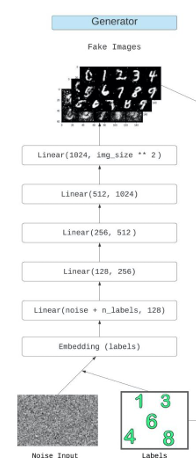

#### Define Discriminator Network

Pada layer output Discriminator berbeda dengan Generator, dimana discriminator menggunakan fungsi aktivasi sigmoid untuk menghasilkan output binary classification real/fake.

In [20]:
image_input = Input(shape=img_shape)

label_input = Input(shape=(1,))
label_embedding = Embedding(num_classes, img_size)(label_input)
label_embedding = Flatten()(label_embedding)

model_input = concatenate([Flatten()(image_input), label_embedding])

x = Dense(512, activation='relu')(model_input)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)   #output fake / real

discriminator_network = Model([image_input, label_input], x)
discriminator_network.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 784)               1568      ['input_4[0][0]']             
                                                                                                  
 flatten_2 (Flatten)         (None, 784)                  0         ['input_3[0][0]']             
                                                                                            

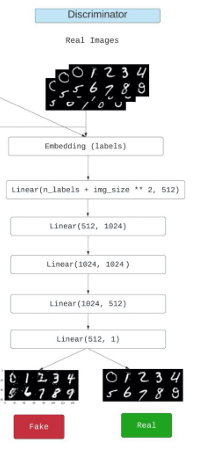

In [21]:
discriminator_network.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

#### GAN, Defining combined model

In [22]:
discriminator_network.trainable = False

generator_output = generator_network([noise_input, label_input])
discriminator_output = discriminator_network([generator_output, label_input])

gan_model = Model([noise_input, label_input], discriminator_output)
gan_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 model (Functional)          (None, 28, 28, 1)            1519448   ['input_1[0][0]',             
                                                                     'input_4[0][0]']             
                                                                                                  
 model_1 (Functional)        (None, 1)                    2905121   ['model[0][0]',         

In [23]:
gan_model.compile(loss='binary_crossentropy', optimizer=Adam(0.00005, 0.5))

#### Define Data Generator

In [24]:
def get_random_noise(batch_size, noise_dim):
    return np.random.normal(0,1, (batch_size, noise_dim))
    # menghasilkan noise acak dari distribusi normal mean 0 dan varians 1 yang digunakan sebagai input untuk generator
    # batch_size untuk menentukan banyaknya sampel noise yang dihasilkan

def get_fake_samples(generator_network, batch_size, noise_dim, num_classes):
    random_noise_batch = get_random_noise(batch_size, noise_dim)
    labels = np.random.randint(0, num_classes, batch_size).reshape(-1,1)
    fake_samples = generator_network.predict([random_noise_batch, labels])
    return fake_samples, labels
    # menghasilkan sampel palsu dari generator dengan input noise dan label yang diberikan

def get_real_samples(batch_size, x_train, y_train):
    indices = np.random.randint(0, x_train.shape[0], batch_size)
    real_images = x_train[indices]
    labels = y_train[indices].reshape(-1, 1)
    return real_images, labels
    # menghasilkan sampel nyata dari train dataset, mengambil sampel secara acak sebanyak batch_size dari x_train
    # dan label yang sesuai dari y_train

def show_generator_results(generator_network, noise_dim, num_classes):
    noise = get_random_noise(9, noise_dim)
    labels = np.array([0, 1, 0, 1, 0, 1, 0, 1, 0]).reshape(-1, 1)
    gen m,erated_images = generator_network.predict([noise, labels])

    plt.figure(figsize=(7, 7))
    for j in range(9):
        plt.subplot(3, 3, j+1)
        plt.imshow(generated_images[j,:,:,-1], cmap='gray_r')
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()
    # menampilkan hasil generator dalam bentuk grid 3x3 dari citra-citra yang dihasilkan
    # yaitu noise acak, label yang digunakan, dan fake images yang dihasilkan dari input noise dan labels

#### Training GAN

2/2 [==============================] - 1s 7ms/step
Epoch 0, Step 0, D Loss: 0.7362511157989502, D Acc: 0.9999999776482582, G Loss: 0.679394006729126
2/2 [==============================] - 0s 7ms/step
Epoch 0, Step 100, D Loss: 0.04990542121231556, D Acc: 99.00000095367432, G Loss: 5.184575080871582
2/2 [==============================] - 0s 10ms/step
Epoch 0, Step 200, D Loss: 0.017245366470888257, D Acc: 99.00000095367432, G Loss: 5.842740058898926
2/2 [==============================] - 0s 5ms/step
Epoch 0, Step 300, D Loss: 0.29019831120967865, D Acc: 88.99999856948853, G Loss: 5.848919868469238
2/2 [==============================] - 0s 5ms/step
Epoch 0, Step 400, D Loss: 0.022320316173136234, D Acc: 100.0, G Loss: 4.838034629821777
1/1 [==============================] - 0s 59ms/step


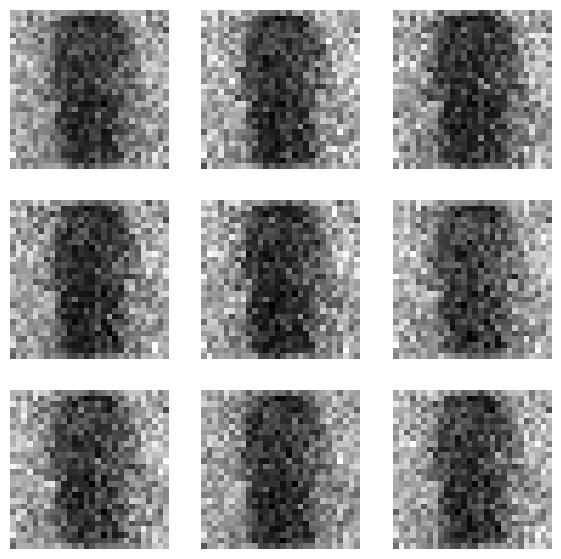

2/2 [==============================] - 0s 5ms/step
Epoch 1, Step 0, D Loss: 0.04326656833291054, D Acc: 98.00000190734863, G Loss: 4.736963272094727
2/2 [==============================] - 0s 7ms/step
Epoch 1, Step 100, D Loss: 0.1532076671719551, D Acc: 93.99999976158142, G Loss: 3.434541702270508
2/2 [==============================] - 0s 5ms/step
Epoch 1, Step 200, D Loss: 1.2271400690078735, D Acc: 49.000000953674316, G Loss: 3.9632699489593506
2/2 [==============================] - 0s 7ms/step
Epoch 1, Step 300, D Loss: 0.06644940190017223, D Acc: 98.00000190734863, G Loss: 4.255679130554199
2/2 [==============================] - 0s 7ms/step
Epoch 1, Step 400, D Loss: 0.135157510638237, D Acc: 94.9999988079071, G Loss: 3.605208158493042
1/1 [==============================] - 0s 18ms/step


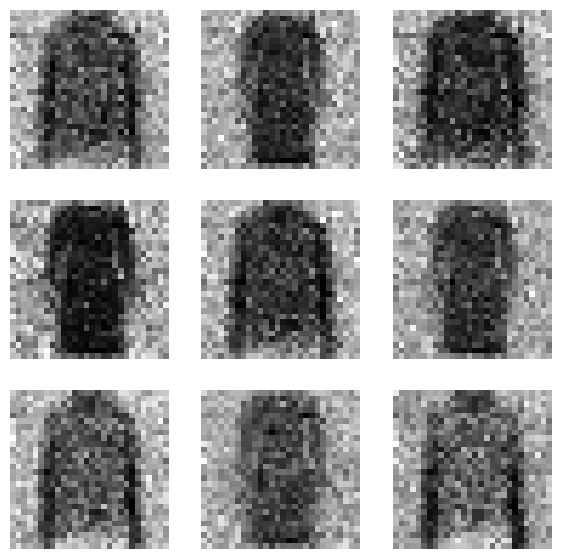

2/2 [==============================] - 0s 6ms/step
Epoch 2, Step 0, D Loss: 0.26810169219970703, D Acc: 90.99999964237213, G Loss: 4.116920471191406
2/2 [==============================] - 0s 6ms/step
Epoch 2, Step 100, D Loss: 0.05490412935614586, D Acc: 99.00000095367432, G Loss: 3.374692440032959
2/2 [==============================] - 0s 9ms/step
Epoch 2, Step 200, D Loss: 1.830555945634842, D Acc: 62.00000047683716, G Loss: 1.6358041763305664
2/2 [==============================] - 0s 6ms/step
Epoch 2, Step 300, D Loss: 0.19065987691283226, D Acc: 88.99999856948853, G Loss: 3.2853455543518066
2/2 [==============================] - 0s 6ms/step
Epoch 2, Step 400, D Loss: 0.2194786574691534, D Acc: 88.99999856948853, G Loss: 3.5338294506073
1/1 [==============================] - 0s 19ms/step


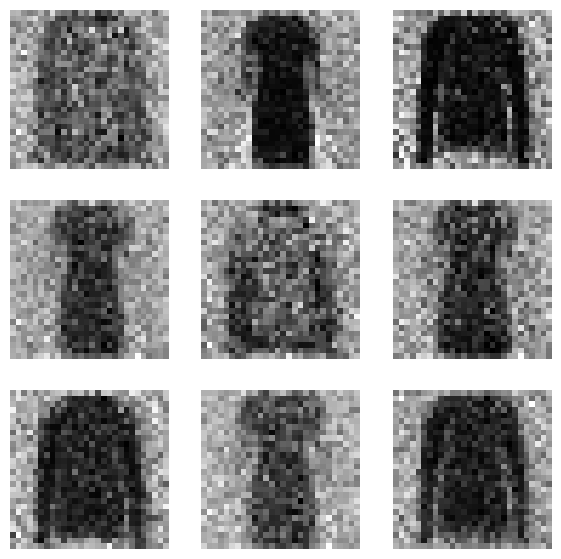

2/2 [==============================] - 0s 6ms/step
Epoch 3, Step 0, D Loss: 0.23944302275776863, D Acc: 92.00000166893005, G Loss: 3.116485595703125
2/2 [==============================] - 0s 5ms/step
Epoch 3, Step 100, D Loss: 0.18065107613801956, D Acc: 93.99999976158142, G Loss: 3.052452802658081
2/2 [==============================] - 0s 7ms/step
Epoch 3, Step 200, D Loss: 0.2916731983423233, D Acc: 83.99999737739563, G Loss: 2.942542314529419
2/2 [==============================] - 0s 6ms/step
Epoch 3, Step 300, D Loss: 0.21738840639591217, D Acc: 92.9999977350235, G Loss: 3.3063912391662598
2/2 [==============================] - 0s 4ms/step
Epoch 3, Step 400, D Loss: 0.45912547409534454, D Acc: 84.00000035762787, G Loss: 4.798305511474609
1/1 [==============================] - 0s 18ms/step


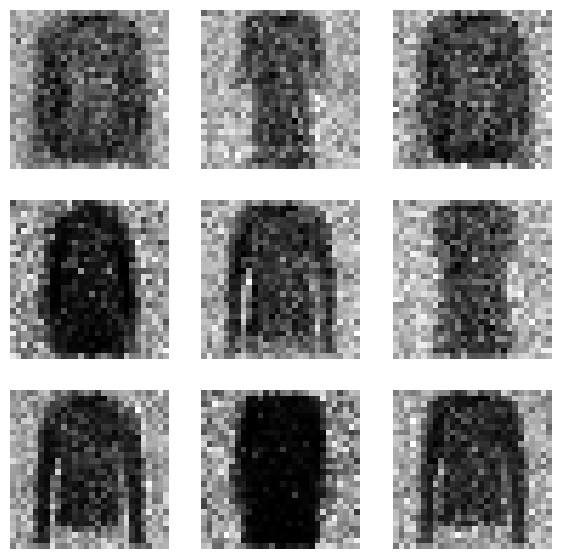

2/2 [==============================] - 0s 4ms/step
Epoch 4, Step 0, D Loss: 0.21175339072942734, D Acc: 94.9999988079071, G Loss: 3.7444710731506348
2/2 [==============================] - 0s 4ms/step
Epoch 4, Step 100, D Loss: 0.12931376323103905, D Acc: 95.99999785423279, G Loss: 3.4844422340393066
2/2 [==============================] - 0s 4ms/step
Epoch 4, Step 200, D Loss: 0.30189019441604614, D Acc: 90.99999964237213, G Loss: 2.9805407524108887
2/2 [==============================] - 0s 4ms/step
Epoch 4, Step 300, D Loss: 0.3268462121486664, D Acc: 85.99999845027924, G Loss: 3.125631809234619
2/2 [==============================] - 0s 5ms/step
Epoch 4, Step 400, D Loss: 0.3076651692390442, D Acc: 87.99999952316284, G Loss: 3.5004770755767822
1/1 [==============================] - 0s 18ms/step


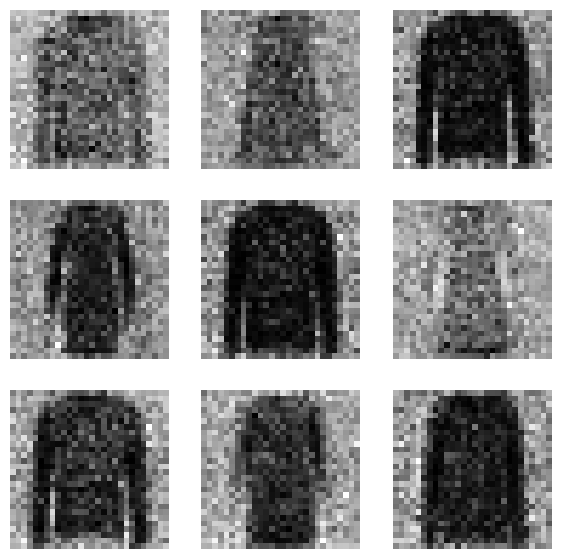

2/2 [==============================] - 0s 6ms/step
Epoch 5, Step 0, D Loss: 0.14488522335886955, D Acc: 94.9999988079071, G Loss: 2.889111280441284
2/2 [==============================] - 0s 6ms/step
Epoch 5, Step 100, D Loss: 0.22125089913606644, D Acc: 90.00000059604645, G Loss: 3.2692317962646484
2/2 [==============================] - 0s 6ms/step
Epoch 5, Step 200, D Loss: 0.23195696622133255, D Acc: 92.00000166893005, G Loss: 3.1201250553131104
2/2 [==============================] - 0s 3ms/step
Epoch 5, Step 300, D Loss: 0.27087507396936417, D Acc: 93.00000071525574, G Loss: 3.7426702976226807
2/2 [==============================] - 0s 4ms/step
Epoch 5, Step 400, D Loss: 0.17554055899381638, D Acc: 93.00000071525574, G Loss: 3.4864957332611084
1/1 [==============================] - 0s 19ms/step


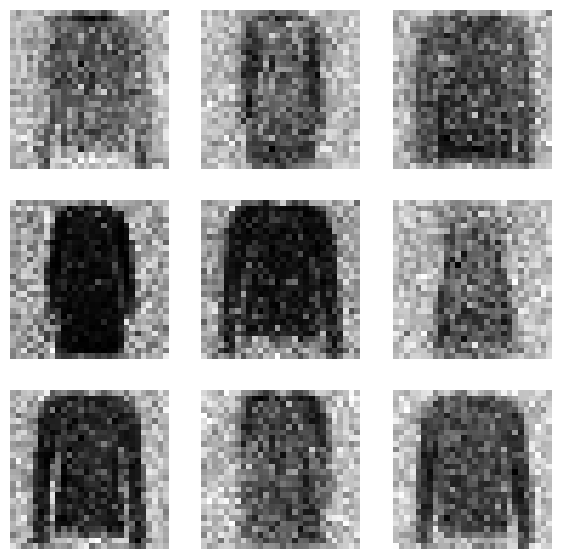

2/2 [==============================] - 0s 5ms/step
Epoch 6, Step 0, D Loss: 0.31644731760025024, D Acc: 83.99999737739563, G Loss: 3.393049955368042
2/2 [==============================] - 0s 5ms/step
Epoch 6, Step 100, D Loss: 0.06562207825481892, D Acc: 97.9999989271164, G Loss: 3.4668796062469482
2/2 [==============================] - 0s 6ms/step
Epoch 6, Step 200, D Loss: 0.20640406757593155, D Acc: 89.99999761581421, G Loss: 3.280280828475952
2/2 [==============================] - 0s 4ms/step
Epoch 6, Step 300, D Loss: 0.2005373165011406, D Acc: 90.99999964237213, G Loss: 4.1092753410339355
2/2 [==============================] - 0s 6ms/step
Epoch 6, Step 400, D Loss: 0.17013007402420044, D Acc: 91.99999868869781, G Loss: 3.397538185119629
1/1 [==============================] - 0s 22ms/step


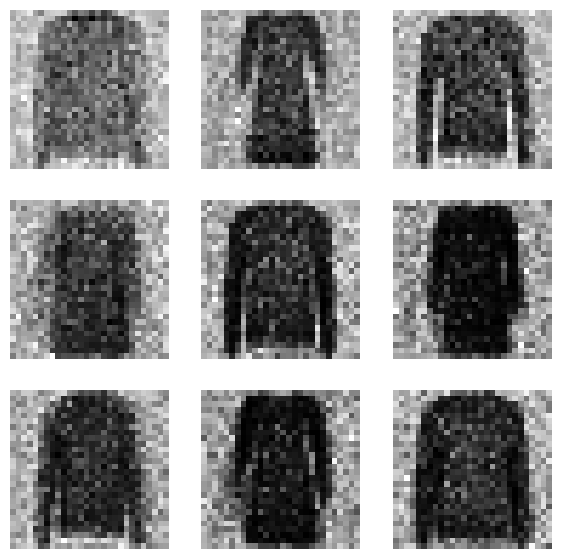

2/2 [==============================] - 0s 5ms/step
Epoch 7, Step 0, D Loss: 0.22942563146352768, D Acc: 90.99999964237213, G Loss: 3.4087133407592773
2/2 [==============================] - 0s 4ms/step
Epoch 7, Step 100, D Loss: 0.5404934287071228, D Acc: 76.99999809265137, G Loss: 2.5705807209014893
2/2 [==============================] - 0s 4ms/step
Epoch 7, Step 200, D Loss: 0.35265301167964935, D Acc: 84.00000035762787, G Loss: 3.6359565258026123
2/2 [==============================] - 0s 4ms/step
Epoch 7, Step 300, D Loss: 0.19901783019304276, D Acc: 90.99999964237213, G Loss: 3.3521714210510254
2/2 [==============================] - 0s 5ms/step
Epoch 7, Step 400, D Loss: 0.2589775621891022, D Acc: 85.99999845027924, G Loss: 3.7693569660186768
1/1 [==============================] - 0s 20ms/step


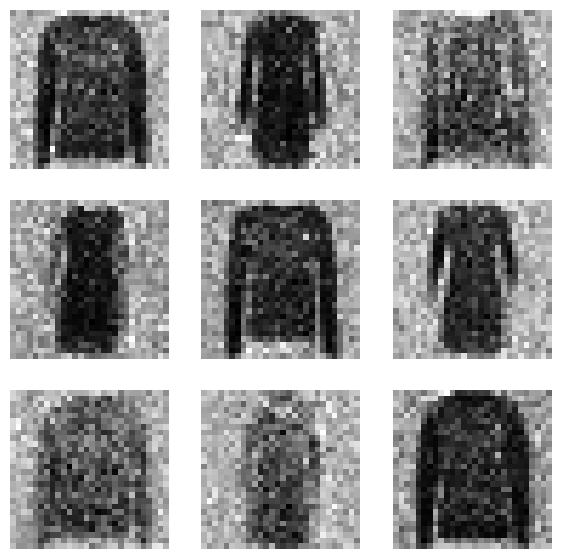

2/2 [==============================] - 0s 6ms/step
Epoch 8, Step 0, D Loss: 0.17595969140529633, D Acc: 92.9999977350235, G Loss: 3.066622018814087
2/2 [==============================] - 0s 5ms/step
Epoch 8, Step 100, D Loss: 0.1922968253493309, D Acc: 91.99999868869781, G Loss: 3.159059524536133
2/2 [==============================] - 0s 4ms/step
Epoch 8, Step 200, D Loss: 0.18207889795303345, D Acc: 95.00000178813934, G Loss: 2.6273412704467773
2/2 [==============================] - 0s 6ms/step
Epoch 8, Step 300, D Loss: 0.28049779683351517, D Acc: 85.99999845027924, G Loss: 2.9274845123291016
2/2 [==============================] - 0s 4ms/step
Epoch 8, Step 400, D Loss: 0.25771240144968033, D Acc: 87.99999952316284, G Loss: 3.1465609073638916
1/1 [==============================] - 0s 29ms/step


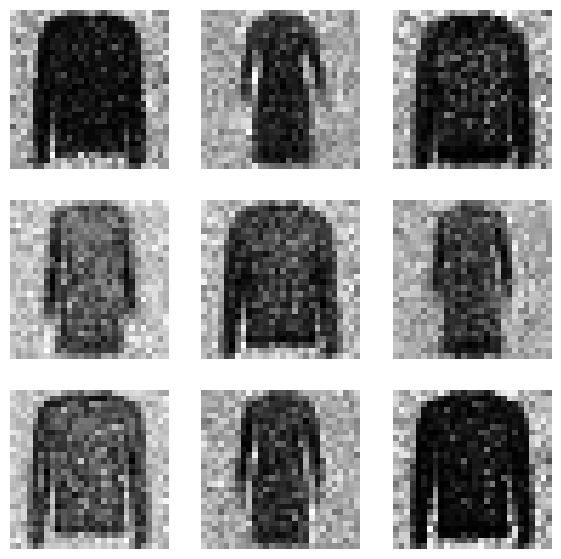

2/2 [==============================] - 0s 5ms/step
Epoch 9, Step 0, D Loss: 0.08812025003135204, D Acc: 96.00000083446503, G Loss: 3.4372689723968506
2/2 [==============================] - 0s 6ms/step
Epoch 9, Step 100, D Loss: 0.2971382588148117, D Acc: 90.00000059604645, G Loss: 3.157390832901001
2/2 [==============================] - 0s 4ms/step
Epoch 9, Step 200, D Loss: 0.38651351630687714, D Acc: 90.00000059604645, G Loss: 3.1833410263061523
2/2 [==============================] - 0s 9ms/step
Epoch 9, Step 300, D Loss: 0.15426821261644363, D Acc: 95.00000178813934, G Loss: 3.285092353820801
2/2 [==============================] - 0s 10ms/step
Epoch 9, Step 400, D Loss: 0.243081197142601, D Acc: 90.99999964237213, G Loss: 3.246978521347046
1/1 [==============================] - 0s 26ms/step


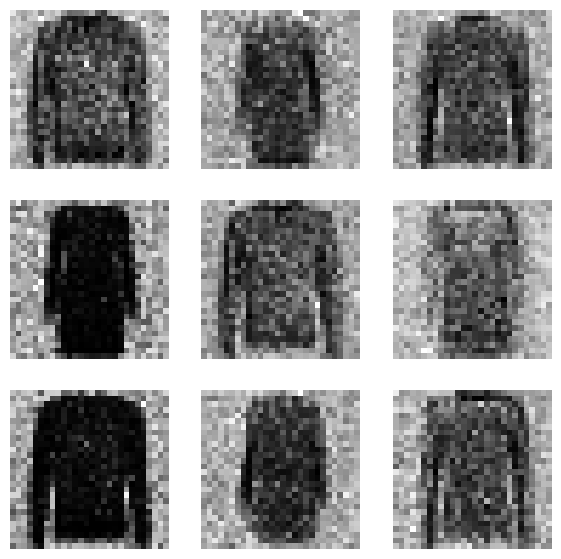

1/1 [==============================] - 0s 36ms/step


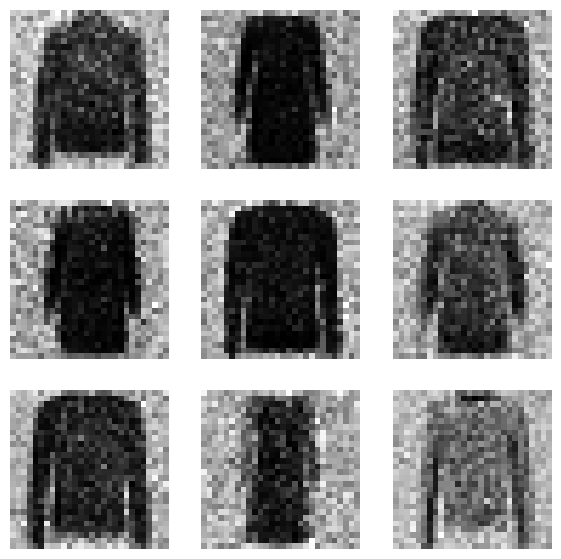

In [25]:
epochs = 10
batch_size = 100
steps = 500

losses_d = []   # array untuk menyimpan loss dari discriminator
losses_g = []   # array untuk menyimpan loss dari generator

for epoch in range(epochs):
    for step in range(steps):
        # ---- Input Discriminator
        real_images, real_labels = get_real_samples(batch_size // 2, x_train, y_train)
        fake_images, fake_labels = get_fake_samples(generator_network, batch_size // 2, noise_dim, num_classes)
        # mendapatkan sampel real dan fake images masing-masing sebanyak batch_size // 2

        real_y = np.ones((batch_size // 2, 1))    # label 1 untuk real image
        fake_y = np.zeros((batch_size // 2, 1))   # label 0 untuk fake image

        # melatih 1 batch pelatihan discriminator dan menghitung nilai loss discriminator
        d_loss_real = discriminator_network.train_on_batch([real_images, real_labels], real_y)
        d_loss_fake = discriminator_network.train_on_batch([fake_images, fake_labels], fake_y)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---- Input Generator
        noise = get_random_noise(batch_size, noise_dim)
        sampled_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        valid_y = np.ones((batch_size, 1))
        # valid_y digunakan untuk memberikan label 1 pada generated_image untuk menipu discriminator

        # melatih 1 batch pelatihan gan model untuk generate fake image
        g_loss = gan_model.train_on_batch([noise, sampled_labels], valid_y)

        losses_d.append(d_loss[0])
        losses_g.append(g_loss)

        # mencetak nilai loss setiap 100 steps
        if step % 100 == 0:
            print(f"Epoch {epoch}, Step {step}, D Loss: {d_loss[0]}, D Acc: {100 * d_loss[1]}, G Loss: {g_loss}")

    if epoch % 1 == 0:
        show_generator_results(generator_network, noise_dim, num_classes)

show_generator_results(generator_network, noise_dim, num_classes)

1/1 [==============================] - 0s 60ms/step


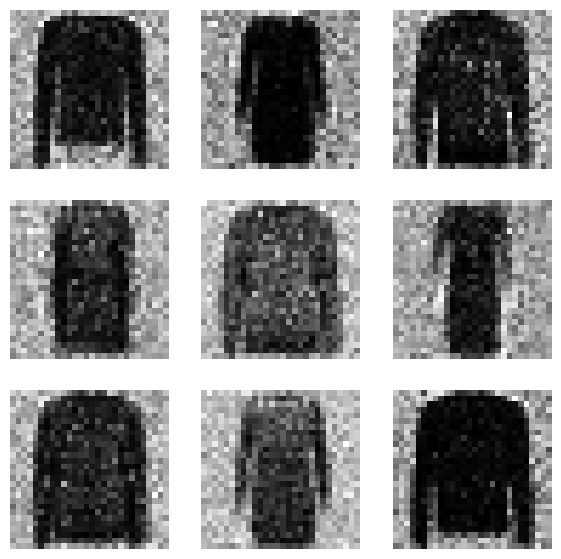

1/1 [==============================] - 0s 78ms/step


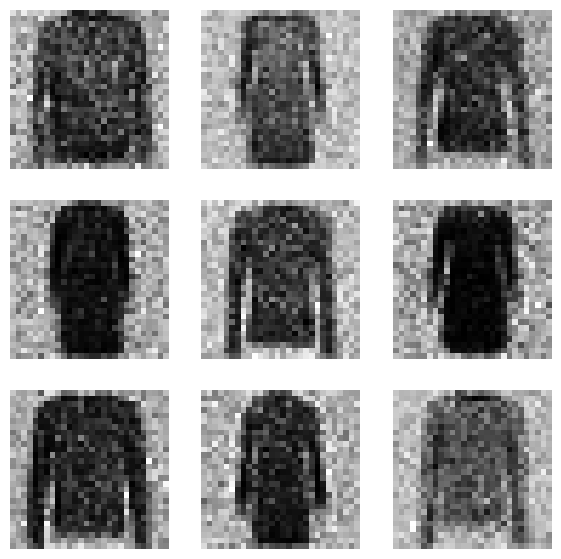

1/1 [==============================] - 0s 233ms/step


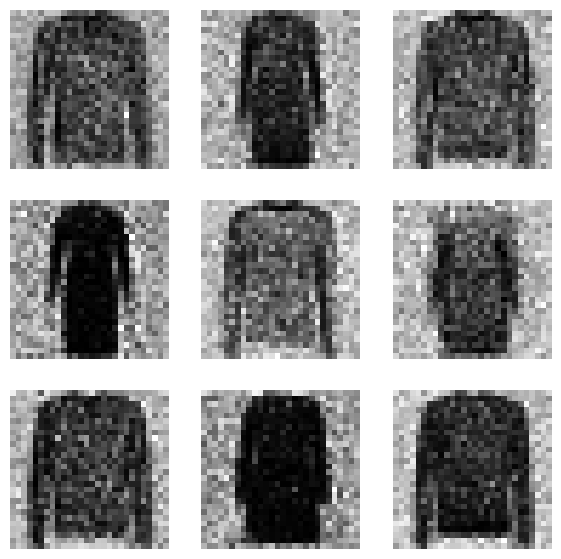

1/1 [==============================] - 0s 34ms/step


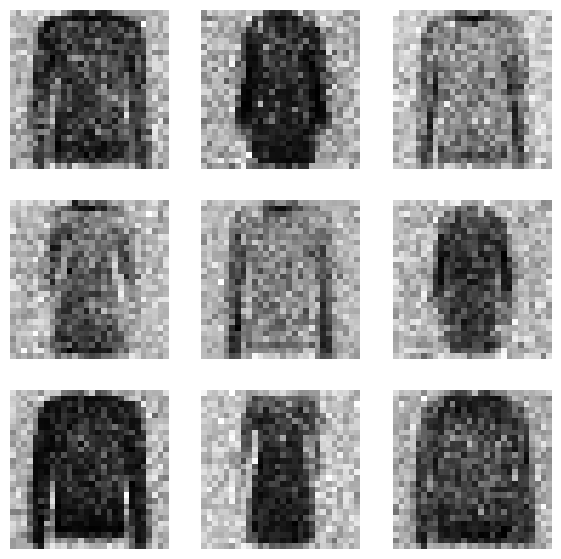

1/1 [==============================] - 0s 37ms/step


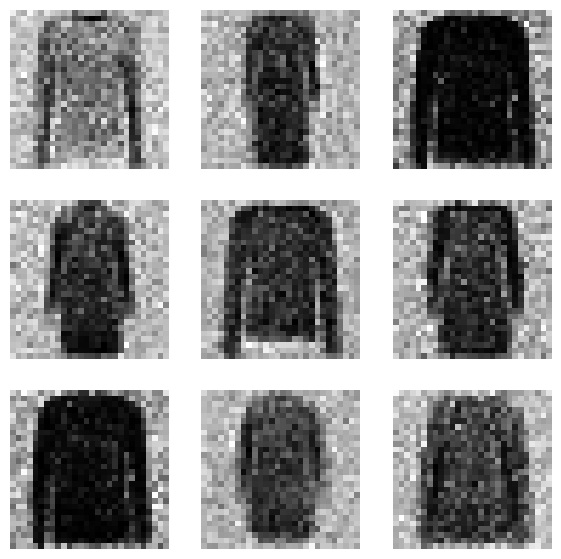

In [28]:
# menampilkan images yang dihasilkan oleh generator dengan menggunakan input noise acak dan label
for i in range(5):
    show_generator_results(generator_network, noise_dim, num_classes)

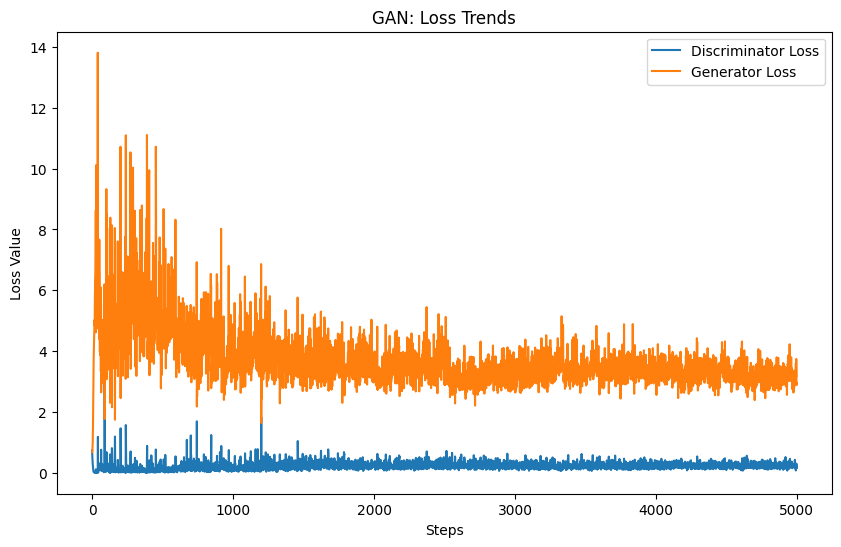

In [29]:
steps = [i for i in range(len(losses_d))]
plt.figure(figsize=(10, 6))
plt.plot(losses_d[:5000])
plt.plot(losses_g[:5000])
plt.xlabel('Steps')
plt.ylabel('Loss Value')
plt.title("GAN: Loss Trends")
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show()

* **Loss Discriminator:** <br>
Tren awal pada steps 0-1000, discriminator menunjukkan nilai loss yang relatif tinggi dan bervariasi naik turunnya. <br>
Setelah beberapa steps (>1000), nilai loss discriminator semakin stabil dan rendah. <br>
Hal ini menunjukkan bahwa pada awalnya discriminator kesulitan dalam membedakan real image dan fake image yang dihasilkan oleh generator, namun semakin lama steps pelatihan discriminator semakin baik dalam membedakan real image dan fake image. <br>

* **Loss Generator:** <br>
Tren awal pada steps 0-500, generator menunjukkan nilai loss yang sangat tinggi dan fluktuatif. Hal ini menunjukkan pada awal pelatihan, generator tidak mampu menghasilkan fake image yang cukup meyakinkan untuk menipu discriminator. <br>
Namun, semakin lama steps pelatihan, generator mulai menghasilkan fake image yang lebih realistis dengan real image.

#### Evaluasi FID

FID (Frechet Inception Distance) adalah nilai yang mengukur seberapa mirip distribusi real image dan fake image. Nilai yang lebih rendah menunjukkan bahwa fake image lebih mirip dengan real image. <br>
Rumus FID:<br>
FID = SSD + trace (sigma1 + sigma2 - 2 * covariance mean)

In [54]:
def calculate_FID(model, real_images, fake_images):
  def calculate_activation_statistics(images, model):
    act = model.predict(images)       # memprediksi aktivasi dari input images
    mu = np.mean(act, axis=0)         # menghitung mean dari nilai aktivasi
    sigma = cov(act, rowvar=False)    # menghitung covariance matrix dari aktivasi
    return mu, sigma

  # memproses real dan fake images
  real_images = preprocess_input(real_images)
  fake_images = preprocess_input(fake_images)

  mu1, sigma1 = calculate_activation_statistics(real_images, model)
  mu2, sigma2 = calculate_activation_statistics(fake_images, model)

  ssdiff = np.sum((mu1 - mu2) ** 2.0)   # menghitung SSD (sum of squared differences) antara mean real dan fake images
  covmean = sqrtm(sigma1.dot(sigma2))   # menghitung akar covariance matrix hasil perkalian sigma1 dan sigma2

  if iscomplexobj(covmean):
    covmean = covmean.real
  # hasil dari akar covariance matrix yang digunakan hanya bagian yang hasilnya real

  fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)   # menghitung FID
  return fid

In [55]:
def evaluate_FID(generator, test_images, test_labels, noise_dim, num_samples=1000):
  test_images = test_images / 255.0   # normalization test images [0,1]

  noise = np.random.normal(0, 1, (num_samples, noise_dim))          # input noise acak
  sampled_labels = np.random.randint(0, num_classes, num_samples)   # input label acak untuk setiap sampel
  generated_images = generator.predict([noise, sampled_labels])     # generate fake image

  model = InceptionV3(include_top=False, pooling='avg', input_shape=(75, 75, 3))
  # menggunakan model InceptionV3 yang sudah terlatih dengan dataset ImageNet
  # input shape model menjadi (75,75,3) --> shape yang kompatibel untuk model InceptionV3

  def resize_images(images):
    images_resized = np.zeros((images.shape[0], 75, 75, 3))
    for i, img in enumerate(images):
      img = img.reshape((28, 28))
      img = np.stack([img]*3, axis=-1) # ubah menjadi 3 channel agar sesuai
      img = image.array_to_img(img, scale=False).resize((75, 75))
      images_resized[i] = image.img_to_array(img)
    return images_resized

  test_images_resized = resize_images(test_images)
  generated_images_resized = resize_images(fake_images)

  fid = calculate_FID(model, test_images_resized, generated_images_resized)
  return fid

In [56]:
fid = evaluate_FID(generator_network, x_test, y_test, noise_dim)
print("FID:", fid)

2/2 [==============================] - 2s 2s/step
FID: 800.0000003374306


Nilai FID yang dihasilkan adalah 800, dimana nilai ini termasuk nilai yang sangat tinggi. Hal ini menunjukkan bahwa fake image yang diahsilkan oleh generator dalam model GAN yang dibangun sangat berbeda dari real image Fashion MNIST. <br>

Untuk meningkatkan nilai FID mungkin dapat meninjau kembali arsitektur dari model yang dibangun, dapat menyesuaikan kembali dengan tuning hyperparameter, menerapkan data augmentation, meningkatkan epoch pelatihan, dan lain sebagainya.



---
Fungsi aktivasi ReLU cenderung memberikan hasil yang lebih baik dalam GAN dibandingkan dengan fungsi aktivasi linear karena relu memperkenalkan non-linearitas yang lebih kuat sehingga memungkinkan generator dan diskriminator untuk mempelajari fitur-fitur yang lebih kompleks dan menangkap distribusi data lebih baik. Lalu relu juga tidak rentan terhadap masalah vanishing gradien sehingga memungkinkan pelatihan GAN lebih stabil dan memungkinkan untuk pembelajaran yang lebih cepat dan efisien.